# PPN Dynamic Filtering

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, ThresholdedReLU
from keras.layers import Convolution2D, MaxPooling2D, InputLayer
from keras.regularizers import activity_l2
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import backend as K

from ppap.layers import PPDFN, DFN
from utils import *

Using Theano backend.
Using gpu device 0: GeForce GT 630M (CNMeM is disabled, cuDNN not available)


In [2]:
# Modified version of keras/examples/mnist_cnn.py

batch_size = 100
nb_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Explicitly set dim ordering to theano
K.set_image_dim_ordering('th')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

170500096/170498071 [==============================] - 796s   
Untaring file...
X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [3]:
modelPP = Sequential()
modelPP.add(InputLayer(batch_input_shape=(batch_size, 3, img_rows, img_cols)))
modelPP.add(PPDFN(5))
modelPP.add(Activation('relu'))
modelPP.add(Flatten())
modelPP.add(Dense(nb_classes))
modelPP.add(Activation('softmax'))

model = Sequential()
model.add(InputLayer(batch_input_shape=(batch_size, 3, img_rows, img_cols)))
model.add(DFN(5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [4]:
modelPP.summary()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 3, 32, 32)      0                                            
____________________________________________________________________________________________________
ppdfn_1 (PPDFN)                  (100, 3, 32, 32)      1610        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (100, 3, 32, 32)      0           ppdfn_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)              (100, 3072)           0           activation_1[0][0]               
___________________________________________________________________________________________

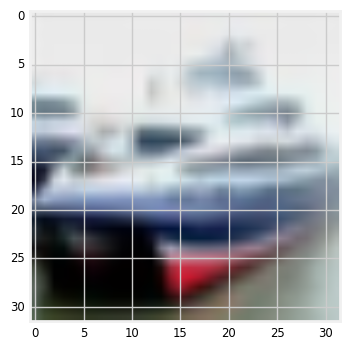

In [6]:
test_index = 1
plt.imshow(X_test[test_index].transpose(1, 2, 0))

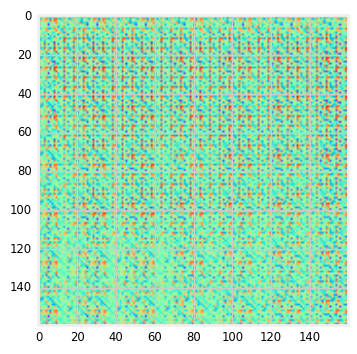

In [7]:
fs = get_filter(modelPP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

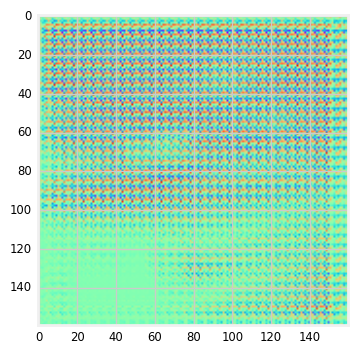

In [8]:
fs = get_filter(model, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 153s - loss: 1.9425 - acc: 0.3036 - val_loss: 1.7367 - val_acc: 0.3827
Epoch 2/10
50000/50000 [==============================] - 150s - loss: 1.6752 - acc: 0.4073 - val_loss: 1.6345 - val_acc: 0.4187
Epoch 3/10
50000/50000 [==============================] - 152s - loss: 1.6003 - acc: 0.4322 - val_loss: 1.5788 - val_acc: 0.4360
Epoch 4/10
50000/50000 [==============================] - 154s - loss: 1.5613 - acc: 0.4456 - val_loss: 1.5850 - val_acc: 0.4406
Epoch 5/10
50000/50000 [==============================] - 154s - loss: 1.5235 - acc: 0.4587 - val_loss: 1.5456 - val_acc: 0.4489
Epoch 6/10
50000/50000 [==============================] - 155s - loss: 1.4984 - acc: 0.4682 - val_loss: 1.5356 - val_acc: 0.4409
Epoch 7/10
50000/50000 [==============================] - 155s - loss: 1.4802 - acc: 0.4738 - val_loss: 1.5471 - val_acc: 0.4554
Epoch 8/10
50000/50000 [=======================

In [10]:
modelPP.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
modelPP.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 155s - loss: 1.8015 - acc: 0.3568 - val_loss: 1.5451 - val_acc: 0.4528
Epoch 2/10
50000/50000 [==============================] - 163s - loss: 1.4637 - acc: 0.4846 - val_loss: 1.4383 - val_acc: 0.4929
Epoch 3/10
50000/50000 [==============================] - 153s - loss: 1.3637 - acc: 0.5184 - val_loss: 1.3961 - val_acc: 0.5062
Epoch 4/10
50000/50000 [==============================] - 150s - loss: 1.3071 - acc: 0.5379 - val_loss: 1.3643 - val_acc: 0.5196
Epoch 5/10
50000/50000 [==============================] - 165s - loss: 1.2675 - acc: 0.5537 - val_loss: 1.3414 - val_acc: 0.5317
Epoch 6/10
50000/50000 [==============================] - 162s - loss: 1.2312 - acc: 0.5663 - val_loss: 1.3254 - val_acc: 0.5315
Epoch 7/10
50000/50000 [==============================] - 155s - loss: 1.2043 - acc: 0.5741 - val_loss: 1.3606 - val_acc: 0.5228
Epoch 8/10
50000/50000 [=======================

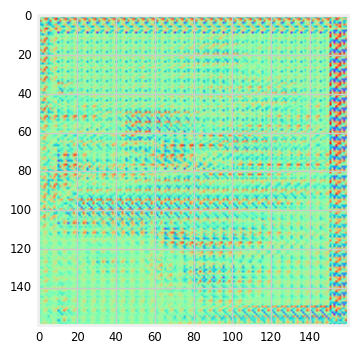

In [11]:
fs = get_filter(model, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))

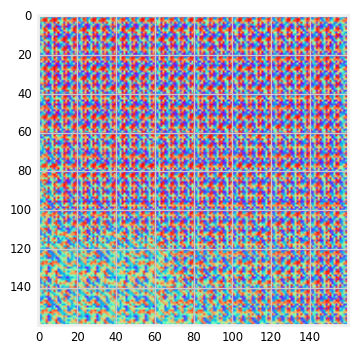

In [12]:
fs = get_filter(modelPP, X_test[:batch_size])
plt.imshow(filters_image(fs[test_index]))